## Preprocessing

### 0. 라이브러리

In [1]:
import pandas as pd
import numpy as np

from konlpy.tag import Okt
from konlpy.jvm import init_jvm # JVM을 초기화하는 함수 init_jvm을 제공

from pykospacing import Spacing # 한글 띄어쓰기 라이브러리
from hanspell import spell_checker # 한글 맞춤법 라이브러리
from tqdm import tqdm # 진행상황 Progress Bar를 위한 tqdm library

from tensorflow.keras.preprocessing.text import Tokenizer
 

### <b>1.0 데이터 불러오기</b>

In [2]:
# 데이터 불러오기

train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

crawl_data = pd.read_csv('./data/naver_train_new.csv')
crawl_data_2 = pd.read_csv('./data/comment_suc.csv', encoding='cp949')


# 데이터 확인

# print(train_data.info()) # 150000 row
# print(test_data.info()) # 50000 row
# print(crawl_data.info()) # 8591 row
# print(crawl_data_2.info()) # 2992 row


# 데이터 결합

train_data = pd.concat([train_data, crawl_data, crawl_data_2], axis=0)
train_data.reset_index(inplace=True, drop=True)

train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
161578,763490752,이런 억지스런 정서와 얄팍한 이야기를.. 감히 시네마천국이라는 명작에 갖다붙여 비...,0
161579,751304283,"100번이고 1000번이고 다시 보고 싶은, 너무나도 소중한 1초!",1
161580,745093399,.,1
161581,741725515,필름에 비치는 나의 모습!! 너무나도 빛나는 나의 심장!! 너무나도 사랑합니다.,1


### <b>2.0 데이터 정제</b>

#### 2.1 중복값 처리

In [103]:
# train_data 중복값 확인

print('train_data')
print('id 중복값: ',         train_data['id'].notnull().sum()        - len(train_data['id'].unique()))
print('document 중복값: ',   train_data['document'].notnull().sum()  - len(train_data['document'].unique()))
print('label 값: ',         train_data['label'].unique(), '\n') # 0, 1


# test_data 중복값 확인

print('test_data')
print('id 중복값: ',       test_data['id'].notnull().sum()        - len(test_data['id'].unique()))
print('document 중복값: ', test_data['document'].notnull().sum()  - len(test_data['document'].unique()))
print('label 값: ',       test_data['label'].unique(), '\n') # 0, 1


# 중복값 제거

train_data.drop_duplicates(['document'], inplace=True)
test_data.drop_duplicates(['document'], inplace=True)

print('train data 개수: ', len(train_data))
print('test data 개수: ', len(test_data))

train_data
id 중복값:  3
document 중복값:  4087
label 값:  [0 1] 

test_data
id 중복값:  0
document 중복값:  839
label 값:  [1 0] 

train data 개수:  156876
test_data 개수:  49158


#### 2.2 구두점, 특수문자 제거

In [104]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') # [ㄱ - ㅎ, ㅏ - ㅣ, 가 - 핳] 제외 제거
train_data['document'] = train_data['document'].str.replace('^ +', '')              # 화이트 스페이스 제거

test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
test_data['document'] = test_data['document'].str.replace('^ +', '')

<ipython-input-104-86c5f8d24f7b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') # [ㄱ - ㅎ, ㅏ - ㅣ, 가 - 핳] 제외 제거
<ipython-input-104-86c5f8d24f7b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', '')              # 화이트 스페이스 제거
<ipython-input-104-86c5f8d24f7b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
<ipython-input-104-86c5f8d24f7b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', '')


#### 2.3 결측치 처리

In [105]:
# 결측치 확인

print('train_data 널값')
print(len(train_data[train_data['document']==""]), train_data['document'].isnull().sum()) # 비어있는 값("") 개수 확인
train_data.replace("", np.nan, inplace=True) # 비어있는 값("") 널값으로 변환

train_data[train_data['document'].isnull()==True]
print(train_data['document'].isnull().sum(), '\n')


print('test_data 널값')
print(len(test_data[test_data['document']==""]), test_data['document'].isnull().sum()) # 비어있는 값("") 개수 확인
test_data.replace("", np.nan, inplace=True) # 비어있는 값("") 널값으로 변환

test_data[test_data['document'].isnull()==True]
print(test_data['document'].isnull().sum(), '\n')


# 결측치 제거

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)


# 결측치 확인

print('남은 넓값: ', train_data['document'].isnull().sum(), test_data['document'].isnull().sum())

print('train data 개수: ', len(train_data))
print('test_data 개수: ', len(test_data))

train_data 널값
824 1
825 

test_data 널값
305 1
306 

남은 넓값:  0 0
train data 개수:  156051
test_data 개수:  48852


#### 2.4 띄어쓰기, 맞춤법

In [108]:
# pykospacing 모듈을 사용하여 띄어쓰기 수행

spacing = Spacing()

train_data['document'] = train_data['document'].apply(spacing)
test_data['document'] = test_data['document'].apply(spacing)

In [109]:
# 띄어쓰기된 파일 별도로 저장

train_data.to_csv('./data/ratings_train_spaced.csv', index=False)
test_data.to_csv('./data/ratings_test_spaced.csv', index=False)

### 3.0 토큰화

In [19]:
# 띄어쓰기된 데이터 불러오기

train_data = pd.read_csv('./data/ratings_train_spaced.csv')
test_data = pd.read_csv('./data/ratings_test_spaced.csv')

In [20]:
# 불용어 사전 불러오기

stopwords = pd.read_csv("./data/stopwords/stopwords_1.csv", encoding='CP949')
stopwords = stopwords['stopwords']
print(len(stopwords))

stopwords_2 = pd.read_table("./data/stopwords/stopwords_2.txt", names=['stopwords', '품사', 'ratio'])
stopwords_2 = stopwords_2['stopwords']
print(len(stopwords_2))

# 불용어 사전 병합

stopwords = pd.concat([stopwords, stopwords_2], axis=0)
stopwords.drop_duplicates(inplace=True)
stopwords.reset_index(inplace=True, drop=True)
print(len(stopwords))

# stopwords.to_csv("./data/stopwords/stopwords_concat.csv", encoding='CP949') 
type(stopwords)


677
100
664


pandas.core.series.Series

#### 3.1 Okt 사용 토큰화

In [21]:
# Okt로 train_data 토큰화

okt = Okt()

okt_train = []

for sentence in tqdm(train_data['document']):            # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    okt_train.append(stopwords_removed_sentence)

pd.Series(okt_train).to_csv("./data/okt/tokenized_train.csv", index=False)

100%|██████████| 156051/156051 [14:17<00:00, 182.05it/s]


In [22]:
# Okt로 test_data 토큰화

okt_test = []

for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    okt_test.append(stopwords_removed_sentence)

pd.Series(okt_test).to_csv("./data/okt/tokenized_test.csv", index=False)

100%|██████████| 48852/48852 [05:12<00:00, 156.50it/s]


#### ~~3.2 꼬꼬마 Kkma 사용 토큰화~~
-> jvm 메모리 에러로 실행 불가, 기각

In [ ]:
from konlpy.tag import Kkma

kkma = Kkma()

test_sentence = train_data.iloc[10, 1]

print('꼬꼬마 형태소 분석 :',kkma.morphs(test_sentence))
print('꼬꼬마 품사 태깅 :',kkma.pos(test_sentence))
print('꼬꼬마 명사 추출 :',kkma.nouns(test_sentence))

꼬꼬마 형태소 분석 : ['걍', '인피', '니트', '가', '짱', '이', '다', '진짜', '짱', '이', '다']
꼬꼬마 품사 태깅 : [('걍', 'MAG'), ('인피', 'NNG'), ('니트', 'NNG'), ('가', 'JKS'), ('짱', 'NNG'), ('이', 'JKS'), ('다', 'MAG'), ('진짜', 'MAG'), ('짱', 'NNG'), ('이', 'VCP'), ('다', 'EFN')]
꼬꼬마 명사 추출 : ['인피', '인피니트', '니트', '짱']


In [ ]:
init_jvm(jvmpath=None, max_heap_size='9096M')

In [ ]:
kkma_x_train = []

for sentence in tqdm(train_data['document']): # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    kkma_x_train.append(stopwords_removed_sentence)

#### 3.3 Mecab 은전한닢 형태소 분석기

https://eunjeon.blogspot.com/

https://cleancode-ws.tistory.com/97

https://m.blog.naver.com/PostView.nhn?blogId=aul-_-&logNo=221557243190&proxyReferer=https:%2F%2Fwww.google.com%2F

In [4]:
from eunjeon import Mecab
mecab=Mecab()

In [5]:
mecab_train = []

for sentence in tqdm(train_data['document']): # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_train.append(stopwords_removed_sentence)
pd.Series(mecab_train).to_csv("./data/mecab/tokenized_train.csv", index=False) 

100%|██████████| 156051/156051 [03:57<00:00, 656.13it/s]


In [6]:
mecab_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_test.append(stopwords_removed_sentence)
pd.Series(mecab_test).to_csv("./data/mecab/tokenized_test.csv", index=False)

100%|██████████| 48852/48852 [01:10<00:00, 690.41it/s]


#### 3.4 코모란 KOMORAN 사용 토큰화

#### 3.5 한나눔 Hannanum 사용 토큰화

### <b>4.0 정수 인코딩</b>

#### 4.1 Okt 정수 인코딩

In [8]:
# 토큰화 완료되어 csv 형식으로 저장한 데이터 불러오기

X_train = pd.read_csv('./data/okt/tokenized_train.csv')
X_train = pd.Series(X_train['0'])

X_test = pd.read_csv("./data/okt/tokenized_test.csv")
X_test = pd.Series(X_test['0'])

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 41851
등장 빈도가 2번 이하인 희귀 단어의 수: 22907
단어 집합에서 희귀 단어의 비율: 54.73465389118539
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9827146161133724
단어 집합의 크기 : 18945


In [10]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

#### 4.2 Mecab 정수 인코딩

In [6]:
# 토큰화 완료되어 csv 형식으로 저장한 데이터 불러오기

X_train = pd.read_csv('./data/mecab/tokenized_train.csv')
X_train = pd.Series(X_train['0'])

X_test = pd.read_csv("./data/mecab/tokenized_test.csv")
X_test = pd.Series(X_test['0'])

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 46728
등장 빈도가 2번 이하인 희귀 단어의 수: 25281
단어 집합에서 희귀 단어의 비율: 54.10246533127889
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1886643607430543
단어 집합의 크기 : 21448


In [9]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### <b>5.0 패딩</b>

#### 5.1 Okt 패딩

In [11]:
# 문장 길이가 0 인 로우 삭제

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print('train data 개수: ', len(train_data))
print('test data 개수: ', len(test_data))

train data 개수:  161583
test data 개수:  50000


C:\Users\Huitaek\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 239
리뷰의 평균 길이 : 8.998630753407046


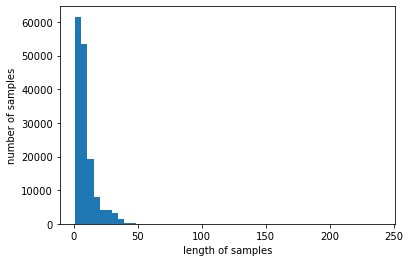

전체 샘플 중 길이가 30 이하인 샘플의 비율: 97.1232964772435


In [13]:
# max_len 결정

import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
    
    

max_len = 30
below_threshold_len(max_len, X_train)

In [14]:
# max_len 에 맞게 데이터셋 패딩

from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [15]:
# 데이터 셋 저장

temp = pd.DataFrame(X_train)
temp.to_csv('./data/okt/X_train.csv', index=False)
temp = pd.DataFrame(X_test)
temp.to_csv('./data/okt/X_test.csv', index=False)
temp = pd.DataFrame(y_train)
temp.to_csv('./data/okt/y_train.csv', index=False)
temp = pd.DataFrame(y_test)
temp.to_csv('./data/okt/y_test.csv', index=False)

print(len(X_train), len(X_test), len(y_train), len(y_test))

155560 48852 161092 50000


#### 5.2 Mecab 패딩

In [10]:
# 문장 길이가 0 인 로우 삭제

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print('train data 개수: ', len(train_data))
print('test data 개수: ', len(test_data))

train data 개수:  156051
test data 개수:  48852


C:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 222
리뷰의 평균 길이 : 9.187508442414691


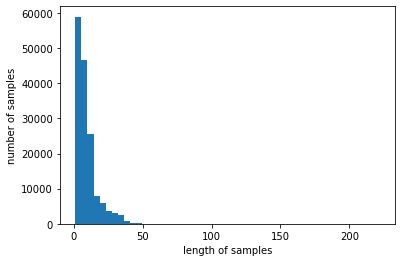

전체 샘플 중 길이가 45 이하인 샘플의 비율: 99.73691827742579


In [11]:
# max_len 결정

import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
    
    

max_len = 45
below_threshold_len(max_len, X_train)

In [12]:
# max_len 에 맞게 데이터셋 패딩

from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [13]:
# 데이터 셋 저장

temp = pd.DataFrame(X_train)
temp.to_csv('./data/mecab/X_train.csv', index=False)
temp = pd.DataFrame(X_test)
temp.to_csv('./data/mecab/X_test.csv', index=False)
temp = pd.DataFrame(y_train)
temp.to_csv('./data/mecab/y_train.csv', index=False)
temp = pd.DataFrame(y_test)
temp.to_csv('./data/mecab/y_test.csv', index=False)

print(len(X_train), len(X_test), len(y_train), len(y_test))

155465 48852 155465 48852
